# Exploratory Data Analysis - How human is Project Miles Ahead?

The point of this notebook is to perform Exploratory Data Analysis (EDA) on the Bill Evan's piece "Waltz for Debbie" and compare it to the same EDA tactics performed on randomly generated music created by the TensFlow model [magenta](https://github.com/tensorflow/magenta) in [Project Miles Ahead](https://github.com/Mithers/Portfolio/tree/master/Project%20Miles%20Ahead) - from this point on referred to simply as Miles.

Theoritcally, this should provide insight in to the "humanity" of the model and music, ultimately, created by a computer.

In [1]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from itertools import izip
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
import sys, copy, random
from music21 import *

The below code will convert the notes text file in to a pandas dataframe allowing for EDA.  

In [4]:
# Import and order the original notes.
debbie = pd.read_csv('notes.txt', skiprows=2)[:].sort_values("Offset") 
debbie.index = xrange(1, len(debbie) + 1)
debbie = debbie[debbie.Octave >= 4] 
with open('notes.txt', 'rb') as f:
    metmark = float(f.readline())
    tsig_num, tsig_den = [i for i in f.readline().replace(' /', '').split()]
    
print "Metrics:" 
print "BPM:", metmark, "Time Signature:", tsig_num, "Offset:", tsig_den, "Count:", len(debbie) 
del debbie["Octave"]
debbie = debbie.rename(columns = {"Note/Rest" : "Note"})
debbie = debbie.reset_index(drop=True)
debbie["FullNote"] = pd.Series(["%s%s" % (i[0], i[1]) for i in debbie.itertuples(index=False)])
debbie.head(5)

Metrics:
BPM: 160.0 Time Signature: 3 Offset: 4 Count: 745


,Note,Len,Offset,FullNote
0,A,1.75,0.000,A1.75
1,C,1.75,0.125,C1.75
2,F,1.25,3.000,F1.25
3,G,1/3,5.500,G1/3
4,G#,0.5,5.750,G#0.5


In [4]:
debbie.dtypes

Note         object
Len          object
Offset      float64
FullNote     object
dtype: object

The parser brought in some len values with a "/".  The below code will replace those with a "." to allow for EDA.

In [6]:
debbie['Len'] = debbie['Len'].map(lambda x: x.replace('/', '.'))

Len needs to be a float object in order to concatenate with Offset

In [7]:
debbie['Len'] = debbie['Len'].astype('float64')

# Rhythmic Analysis

First we take a look at length over offset to get an idea of the rhythmic patterns of Waltz for Debbie:

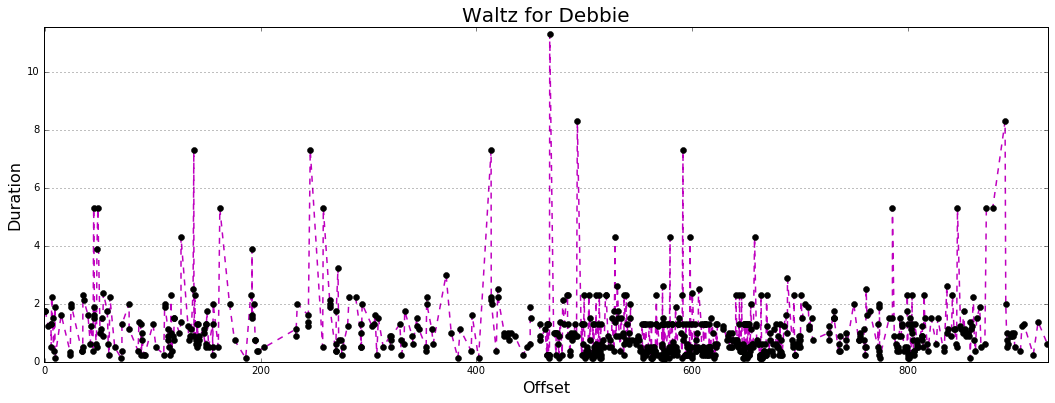

In [14]:
# Plot the length over offset.
# *args is some (n, 2) array you want to plot
def rhythm(data, labels=None, clustercenters=None):
    numberofitems = len(data)
    
    # generate colors
    clusterCodes = dict()
    if labels is not None:
        for i in labels:
            r = lambda: random.randint(0,255)
            clusterCodes[i] = ('#%02X%02X%02X' % (r(),r(),r())).lower()
    
    # Initialize the graph
    dx = data['Offset']
    dy = data['Len']
    dn = data['Note']
    plt.plot(dx, dy, 'm.--', linewidth=1.5)
    for ix, (x, y) in enumerate(zip(dx, dy)):
        color = 'ko'
        if labels is not None:
            color = clusterCodes[labels[ix]]
            plt.plot(x, y, 'x', ms=15, mew=1.5, color=color)
            continue
        plt.plot(x, y, color)

    # plot the cluster centers if available
    if clustercenters is not None:
        for currColorIx, i in enumerate(clustercenters):
            cx = i[0]
            cy = i[1]
            color = clusterCodes[currColorIx]
            plt.plot(cx, cy, 'ko', mew=0, ms=7.5) # plot black. same color: color=color
                
    # plot the ticks if under certain # of points
    if numberofitems <= 100:
        plt.xticks(range(0, int(max(dx)) + 1))

    # Annotate with note data only if under certain # of points
    if numberofitems <= 100 and labels is None:
        for note, offset, length in izip(dn, dx, dy):
            plt.annotate(note, xy=(offset, length), color='g')

    # Set xticks on top
    fig = plt.gcf()
    ax = plt.gca()
    if numberofitems <= 100:
        ax.xaxis.set_tick_params(labeltop='on')

    
    if numberofitems <= 100:
        plt.text(max(dx) / 2, max(dy) + 1.5, 'Waltz for Debbie', fontsize=20, horizontalalignment='center')
    else:
        plt.title('Waltz for Debbie', fontsize=20, horizontalalignment='center')
        
    # set fig limits, size, and other display items
    plt.ylim([0, max(dy)+ 0.25])
    plt.xlim([min(dx) - 1, max(dx) + 1])
    plt.ylabel('Duration', fontsize=16)
    plt.xlabel('Offset', fontsize=16)
    plt.grid()
    fig = plt.gcf()
    fig.set_size_inches(18, 6)
    # plt.xkcd()
    ax.xaxis.grid(False)
    
rhythm(debbie)

We can also cluster these notes with KMeans. Each cluster will have a different color, and the centroid for each one will be a black circle.

In statistics, K-Means is a clustering algorithm that assumes k clusters, and then computes these clusters based on the attributes of the available data. The algorithm takes your entire dataset, in this case debbie, and iterates over its attributes (note length) to determine clusters based around centers(offset), known as centroids.

Doing so with music, particularly with rhythms as we are here, shows us patterns in the players execution - which will be useful in analyzing the music produced by Miles.

In [8]:
notesX = debbie["Offset"].reshape(-1, 1)
notesY = debbie["Len"].reshape(-1, 1)
notesXY = np.concatenate((notesX, notesY), axis=1)
notenames = np.array([i for i in debbie["Note"]])

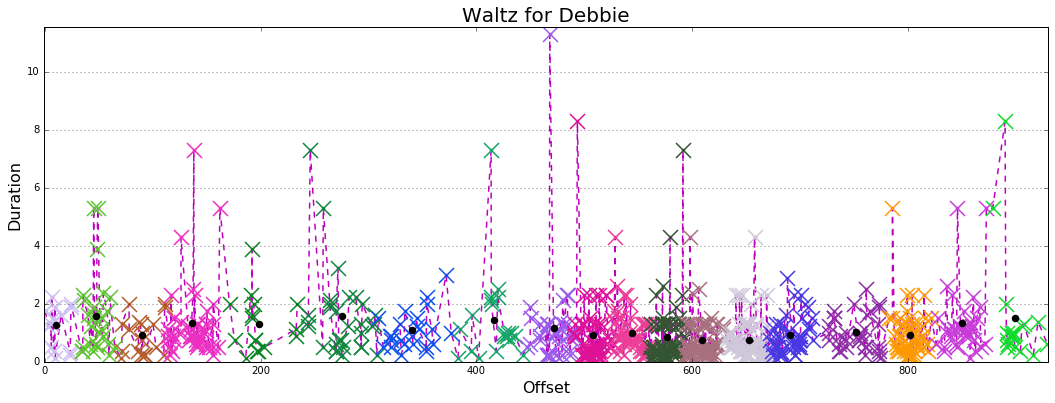

In [9]:
km = KMeans(n_clusters=int(np.sqrt(len(notesX) / 2)))
km.fit(notesXY)
plotTiming(debbie, labels=km.labels_, clustercenters=km.cluster_centers_)

# Tickle those Ivories

An interesting visualization, made possible by music21 is to visualize the notes as played on a keyboard.

745 745


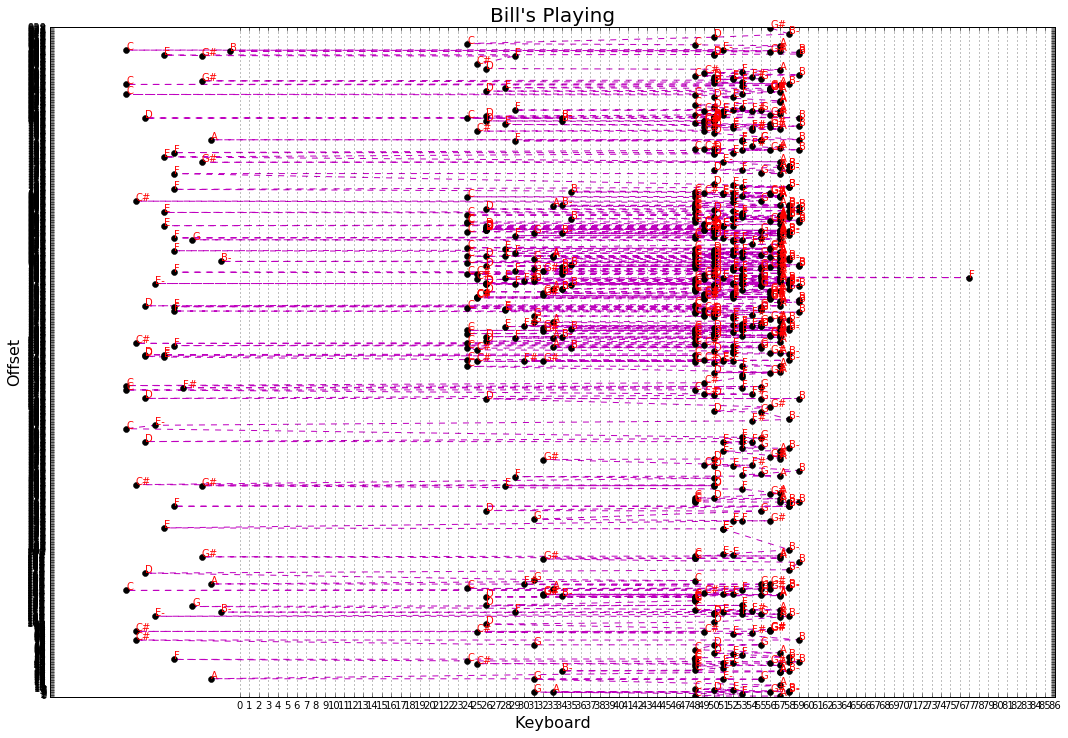

In [16]:
def quantify(note):
    notevals = {
        'C' : 0,
        'D' : 2,
        'E' : 4,
        'F' : 5,
        'G' : 7,
        'A' : 9,
        'B' : 11
    }
    quantized = 0
    octave = int(note[-1]) - 1
    for i in note[:-1]:
        if i in notevals: quantized += notevals[i]
        if i == '-': quantized -= 1
        if i == '#': quantized += 1
    quantized += 12 * octave
    return quantized

# Plot the notes as played by MIDI.
def plotMIDI(data, quantizednotes):
    # Initialize the graph
    dy = debbie['Offset']
    dn = debbie['Note']
    dx = quantizednotes
    print len(dx), len(dy)
    plt.plot(dx, dy, 'm.--', linewidth=1)
    for x, y in zip(dx, dy):
        plt.plot(x, y, 'ko')

    # Plot the ticks
    plt.xticks(range(0, 87))
    plt.yticks(range(0, int(max(dy)+1)))

    # Annotate with note data
    for note, nx, ny in izip(dn, dx, dy):
        plt.annotate(note, xy=(nx, ny), color='r')

    # Set xticks on top
    fig = plt.gcf()
    ax = plt.gca()

    # Set fig limits, size, and other display things
    max_xax = 18
    max_yax = 12
    # max_yax = len(data) / 10
    fig = plt.gcf()
    fig.set_size_inches(max_xax, max_yax)
    plt.ylim([-1, max(dy) + 1])
    plt.title('Bill\'s Playing', fontsize=20, horizontalalignment='center')
    plt.ylabel('Offset', fontsize=16)
    plt.xlabel('Keyboard', fontsize=16)
    plt.grid()
    ax.yaxis.grid(False)
quantizednotes = [quantify(i) for i in debbie['FullNote']]
plotMIDI(debbie, quantizednotes)
plt.show()

# MIDI Analysis

We can also use the midi file itself and music21 to do some basic visualizations on the piece as a whole:

In [11]:
#load the midi in and parse it via the music21 library
debbie2 = converter.parse('debbie.mid')

The below chart shows us the amount of pitches that used quarter notes in the piece and what they were.

The use case of specific notes and note lengths is a good indicator of the versatility of a musician. 

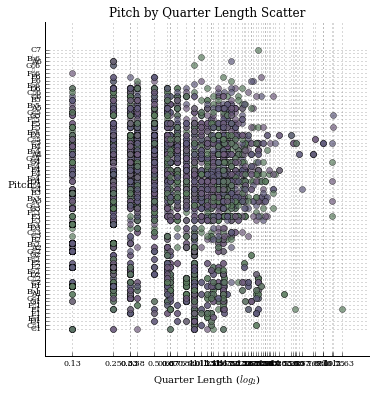

In [12]:
graph.plotStream(debbie2, format='scatter', values=['pitch'])

A simple histogram on the notes used in the piece will help us with the same types of comparison.

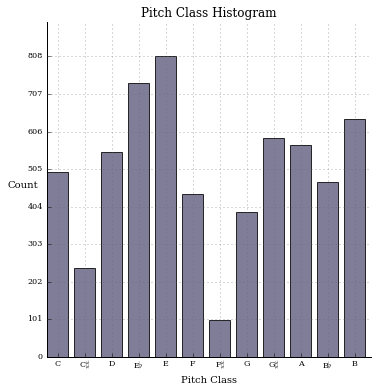

In [13]:
graph.plotStream(debbie2, 'PlotHistogramPitchClass')  

# Miles - Can a computer swing?

Let's take a look at the "solo" piece produced by Miles - which is audibly the most technically proficient of the two recordings.

In [15]:
miles = converter.parse('/Users/Lappy9000/Dropbox/Dropbox/Miles_Ahead/viz testing/solo.mid')

This is just for the music nerd in me who wants to see what computer generated music looks like on sheet music.

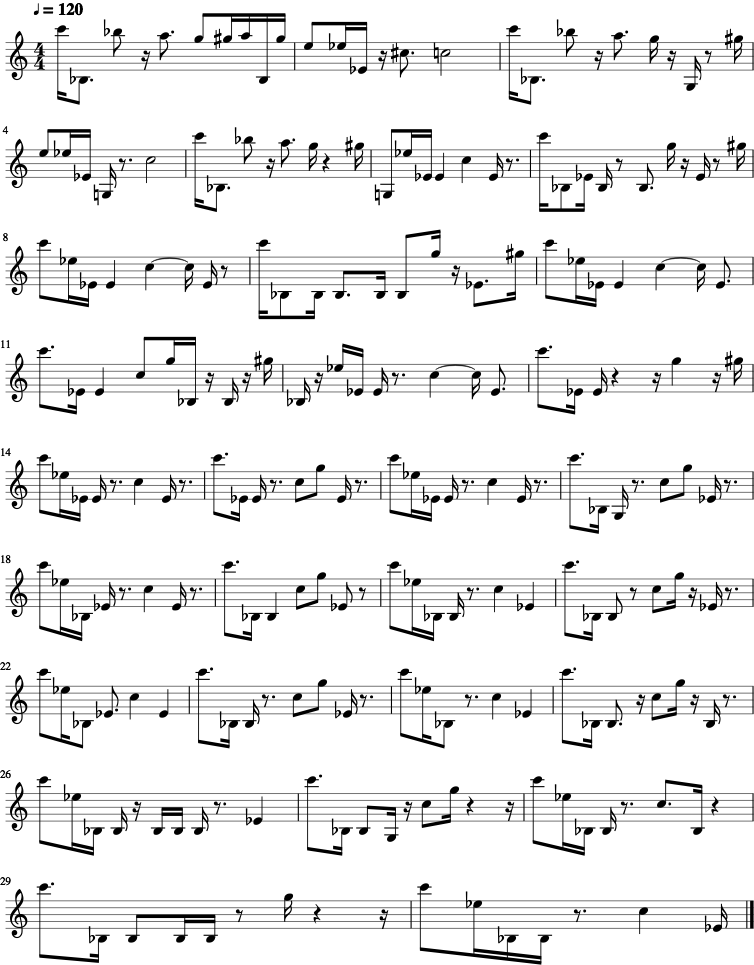

In [16]:
miles.show()

In [17]:
# Import and order the original notes.
miles2 = pd.read_csv('miles_notes.txt', skiprows=2)[:].sort_values("Offset")
miles2.index = xrange(1, len(miles2) + 1)
miles2 = miles2[miles2.Octave >= 4] 
with open('miles_notes.txt', 'rb') as f:
    metmark = float(f.readline())
    tsig_num, tsig_den = [i for i in f.readline().replace(' /', '').split()]
    
print "Metrics:" 
print "BPM:", metmark, "Time Signature:", tsig_num, "Offset:", tsig_den, "Count:", len(debbie) 
del miles2["Octave"]
miles2 = miles2.rename(columns = {"Note/Rest" : "Note"})
miles2 = miles2.reset_index(drop=True)
miles2["FullNote"] = pd.Series(["%s%s" % (i[0], i[1]) for i in debbie.itertuples(index=False)])
miles2.head(5)

Metrics:
BPM: 120.0 Time Signature: 4 Offset: 4 Count: 745


,Note,Len,Offset,FullNote
0,C,0.25,0.00,A1.75
1,B-,0.75,0.25,C1.75
2,B-,0.50,1.00,F1.25
3,Rest,0.25,1.50,G1.3
4,A,0.75,1.75,G#0.5


Perform similar data pruning we did on debbie above:

In [18]:
miles2['Len'] = miles2['Len'].astype('float64')

# Miles has Rhythm...

Applying the same rhythmic analysis to the Miles solo shows a similar rhythmic and k-means clustering pattern as we found in the Bill Evans track.  It is significantly more simplistic, however, than the track performed by Bill Evans.  Perhaps Miles could take some lessons?

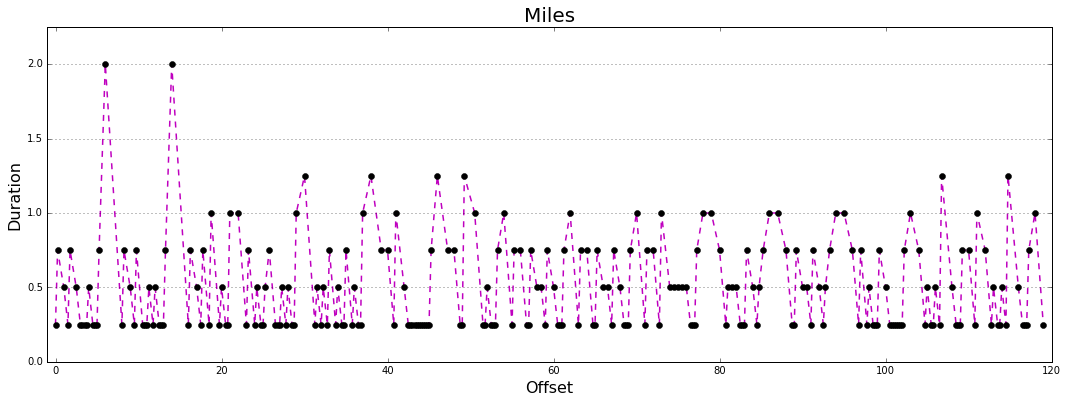

In [28]:
# Plot the length over offset.
# *args is some (n, 2) array you want to plot
def rhythm(data, labels=None, clustercenters=None):
    numberofitems = len(data)
    
    # generate colors
    clusterCodes = dict()
    if labels is not None:
        for i in labels:
            r = lambda: random.randint(0,255)
            clusterCodes[i] = ('#%02X%02X%02X' % (r(),r(),r())).lower()
    
    # Initialize the graph
    dx = data['Offset']
    dy = data['Len']
    dn = data['Note']
    plt.plot(dx, dy, 'm.--', linewidth=1.5)
    for ix, (x, y) in enumerate(zip(dx, dy)):
        color = 'ko'
        if labels is not None:
            color = clusterCodes[labels[ix]]
            plt.plot(x, y, 'x', ms=15, mew=1.5, color=color)
            continue
        plt.plot(x, y, color)

    # plot the cluster centers if available
    if clustercenters is not None:
        for currColorIx, i in enumerate(clustercenters):
            cx = i[0]
            cy = i[1]
            color = clusterCodes[currColorIx]
            plt.plot(cx, cy, 'ko', mew=0, ms=7.5) # plot black. same color: color=color
                
    # plot the ticks if under certain # of points
    if numberofitems <= 100:
        plt.xticks(range(0, int(max(dx)) + 1))

    # Annotate with note data only if under certain # of points
    if numberofitems <= 100 and labels is None:
        for note, offset, length in izip(dn, dx, dy):
            plt.annotate(note, xy=(offset, length), color='g')

    # Set xticks on top
    fig = plt.gcf()
    ax = plt.gca()
    if numberofitems <= 100:
        ax.xaxis.set_tick_params(labeltop='on')

    
    if numberofitems <= 100:
        plt.text(max(dx) / 2, max(dy) + 1.5, 'Waltz for Debbie', fontsize=20, horizontalalignment='center')
    else:
        plt.title('Miles', fontsize=20, horizontalalignment='center')
        
    # set fig limits, size, and other display items
    plt.ylim([0, max(dy)+ 0.25])
    plt.xlim([min(dx) - 1, max(dx) + 1])
    plt.ylabel('Duration', fontsize=16)
    plt.xlabel('Offset', fontsize=16)
    plt.grid()
    fig = plt.gcf()
    fig.set_size_inches(18, 6)
    # plt.xkcd()
    ax.xaxis.grid(False)
    
rhythm(miles2)

In [29]:
notesX2 = miles2["Offset"].reshape(-1, 1)
notesY2 = miles2["Len"].reshape(-1, 1)
notesXY2 = np.concatenate((notesX2, notesY2), axis=1)
notenames2 = np.array([i for i in miles2["Note"]])

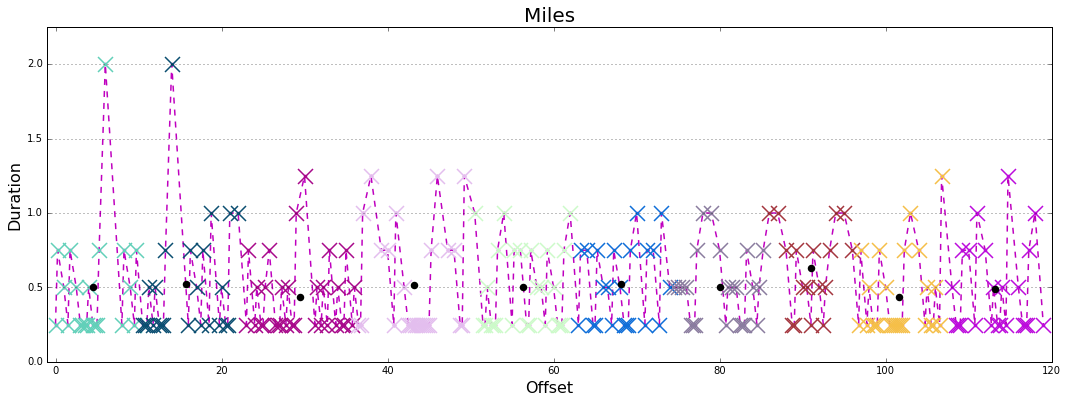

In [30]:
km2 = KMeans(n_clusters=int(np.sqrt(len(notesX2) / 2)))
km2.fit(notesXY2)
plotTiming(miles2, labels=km2.labels_, clustercenters=km2.cluster_centers_)

We see similarities in the keyboard visualization as well, however, once again Miles is not as complicated as his counterpoint in his note selections and patterns.

239 239


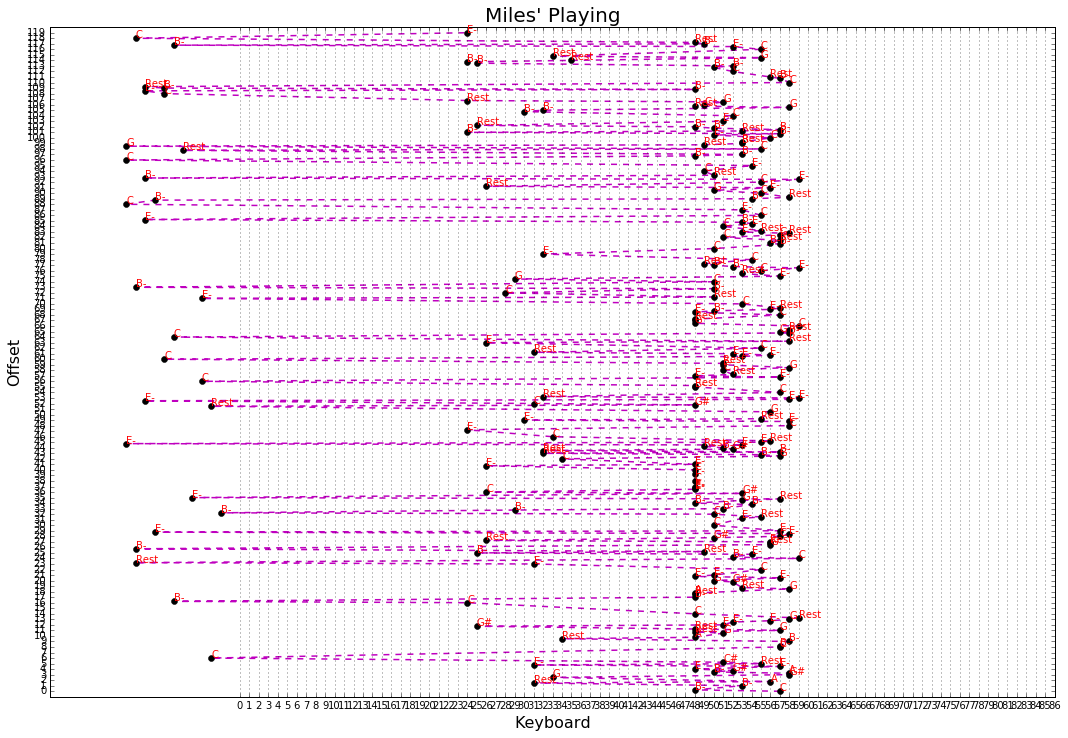

In [19]:
def quantify(note):
    notevals = {
        'C' : 0,
        'D' : 2,
        'E' : 4,
        'F' : 5,
        'G' : 7,
        'A' : 9,
        'B' : 11
    }
    quantized = 0
    octave = int(note[-1]) - 1
    for i in note[:-1]:
        if i in notevals: quantized += notevals[i]
        if i == '-': quantized -= 1
        if i == '#': quantized += 1
    quantized += 12 * octave
    return quantized

# Plot the notes as played by MIDI.
def plotMIDI(data, quantizednotes):
    # Initialize the graph
    dy = miles2['Offset']
    dn = miles2['Note']
    dx = quantizednotes
    print len(dx), len(dy)
    plt.plot(dx, dy, 'm.--', linewidth=1.5)
    for x, y in zip(dx, dy):
        plt.plot(x, y, 'ko')

    # Plot the ticks
    plt.xticks(range(0, 87))
    plt.yticks(range(0, int(max(dy)+1)))

    # Annotate with note data
    for note, nx, ny in izip(dn, dx, dy):
        plt.annotate(note, xy=(nx, ny), color='r')

    # Set xticks on top
    fig = plt.gcf()
    ax = plt.gca()

    # Set fig limits, size, and other display things
    max_xax = 18
    max_yax = 12
    # max_yax = len(data) / 10
    fig = plt.gcf()
    fig.set_size_inches(max_xax, max_yax)
    plt.ylim([-1, max(dy) + 1])
    plt.title('Miles\' Playing', fontsize=20, horizontalalignment='center')
    plt.ylabel('Offset', fontsize=16)
    plt.xlabel('Keyboard', fontsize=16)
    plt.grid()
    ax.yaxis.grid(False)
quantizednotes = [quantify(i) for i in miles2['FullNote']]
plotMIDI(miles2, quantizednotes)
plt.show()

The below charts are unfortunately not as helpful as intended due to the length of the two tracks.  Comparing the entire "Waltz for Debbie" track by Bill Evans to the 30 seconds generated by Miles, is simply not enough data to conclude anything.  However, we could extrapulate from this EDA later by changing the length of one of the songs and renewing our efforts.  I chose to leave it here because it is still interesting to see.

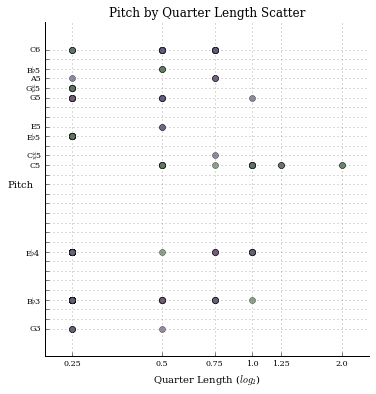

In [34]:
graph.plotStream(miles, format='scatter', values=['pitch'])

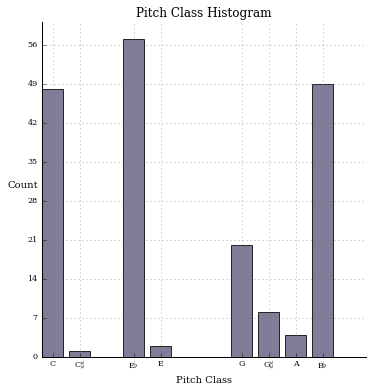

In [35]:
graph.plotStream(miles, 'PlotHistogramPitchClass')  

# Conclusion

The EDA in this notebook seems to hint at a level of "humanity" exhibited in the Miles solo piece as compared to the legendary Bill Evans.

We see similar patterns in rhythmic patterns, statistical clustering, and note selection/patterns in play.  It is a small sample size, but it certainly stands to prove the validity of neural network methodology in machine learning.  

I would like to increase the sample size used in our initial database that drove the generation of the Miles piece and perform more EDA in the future on both sides of the equation to further explore the hypothosis that a computer can make "human" sounding music.

At the end of the day, music is an audible art form, so perhaps the best question is, how did Miles make you feel?